*Note - For most convenient use, upload notebook to google colab and use the index on the left in colab, showing the sections and subsections*

1. First we will import all the required libraries and modules
2. Then we will run all the method definitions, so as to later call them
3. Call the methods in the order - 

*   Preprocessing / train-test-split - Prepreocessing, train_test_split
*   Training-Validation methods - SGD(), ALS()
*   Loading saved model(s) to plot the training validation learning curves
*   Append predicted ratings to test set for comparison
*   Showing recommendations for User - recommend()









# Importing and Installing required libraries and modules

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from numpy import random
from sklearn.utils import shuffle
import math
import pickle
# import tensorflow as tf
import gzip
import json
import itertools
from itertools import product
import time

time: 5.13 ms (started: 2021-05-03 21:34:53 +00:00)


In [ ]:
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.74 s (started: 2021-05-03 21:34:57 +00:00)


# Methods to Run before executing train or predict

### Preprocessing and Splitting into train-test

In [ ]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

def read_Dataset(path):
    return getDF(path)


def Preprocessing(df, min_user_ratings ,min_item_ratings):
    df_copy  = df[df.groupby(['uid']).uid.transform('count')>=min_user_ratings].copy()
    df_copy = df_copy[df_copy.groupby('iid').uid.transform('count')>=min_item_ratings].copy()
    
    # Assigning ids to values
    user_mapping = {v: k for k, v in enumerate(set(df_copy.uid))}
    item_mapping = {v: k for k, v in enumerate(set(df_copy.iid))}
    
    # Mapping user id, item id strings to sequential integer values
    df_copy.uid = df_copy.uid.map(user_mapping)
    df_copy.iid = df_copy.iid.map(item_mapping)
    
    return df_copy, user_mapping, item_mapping


def train_test_split(df_copy):
    train_list = []
    test_list =  []
    surprise_list = []
    size = 0
    user_groups = df_copy.sort_values('timestamp')   # to make sure , for every user, the test set ratings are the most recent
    for user, df in user_groups.groupby("uid"):
        train_size = round(0.8*len(df))
        train_list.append(df[:train_size])
        test_list.append(df[train_size:])
    return pd.concat(train_list), pd.concat(test_list)



time: 38.2 ms (started: 2021-05-03 21:35:10 +00:00)


### SGD Implementation

#### Training with combination of all parameters - best model with least validation mae will be chose and saved

In [ ]:
def SGD(train, test, hyperparameters, file_name, num_epochs, user_mapping, item_mapping, results_df, min_user_rated,min_item_rated):
        
    best_validation_mae = math.inf
    for i, params in enumerate(list(itertools.product(*hyperparameters))):
        early_stopping_count = 0
        lr = params[0]
        reg = params[1]
        n_factors = params[2]
         # Initialization of Vectors
        p = random.rand(len(user_mapping), n_factors)
        q = random.rand(n_factors, len(item_mapping))

        train_mae = [0 for _ in range(num_epochs)]
        train_mse = [0 for _ in range(num_epochs)]
        test_mae = [0 for _ in range(num_epochs)]
        test_mse = [0 for _ in range(num_epochs)]
        print(f'\nTrying with hyperparameters - Learning Rate - {lr}, Regularization(Lambda) - {reg}, No. of Factors/rank - {n_factors}')
        for epoch in range(num_epochs):
          
            # Training 
            for i, row  in train.iterrows():
                # e_ij = row.ratings - p[int(row.uid),:].dot(q[:,int(row.iid)])
                e_ij = row.ratings - p[int(row.uid),:].dot(q[:,int(row.iid)])
                p[int(row.uid),:] = p[int(row.uid),:] + lr*(e_ij*q[:,int(row.iid)].T - reg*p[int(row.uid),:])
                q[:,int(row.iid)] = q[:,int(row.iid)] + lr*(e_ij*p[int(row.uid),:].T - reg*q[:,int(row.iid)])
                train_mae[epoch] += abs(e_ij)
                train_mse[epoch] += e_ij**2
            
            # Validation 
            for i, row  in test.iterrows():
                e_ij = row.ratings - p[int(row.uid),:].dot(q[:,int(row.iid)])
                test_mae[epoch] += abs(e_ij)
                test_mse[epoch] += e_ij**2
            if test_mae[epoch] < best_validation_mae:
                best_validation_mae = test_mae[epoch]
                SGD_model = { 'name':file_name, 'user_vectors':p,'item_vectors':q,
                                           'hyperparameters':params, 'train':train,'test':test, 'train_mse':train_mse,'train_mae':train_mae,
                                           'test_mse':test_mse, 'test_mae':test_mae,
                                                'best_train_mae':train_mae[epoch],'best_test_mae':test_mae[epoch],
                                            'user_mapping':user_mapping, 'item_mapping':item_mapping}
            # Early stopping criteria
            
            if test_mae[epoch] >= test_mae[epoch-1] and epoch > 0:
                early_stopping_count += 1
            else:
                early_stopping_count = 0
            
            if early_stopping_count > 5:
                break
                
            # Displaying Loss Function Values
            print(f'\nEpoch {epoch} - \n')
            print(f'Training Error (MAE) {round(train_mae[epoch]/len(train),3)} (MSE) {round(train_mse[epoch]/len(train), 3)}', end='\t')
            print(f'Validation Error (MAE) {round(test_mae[epoch]/len(test),3)} (MSE) {round(test_mse[epoch]/len(test), 3)}')
            

        pickle.dump(SGD_model, open( file_name, "wb" ) )
        hyperparam_all = {'lr':hyperparameters[0],'reg':hyperparameters[1],'factors':hyperparameters[2]}
        results_df.loc[len(results_df)] =[SGD_model['name'],len(SGD_model['train']),len(SGD_model['test']),SGD_model['best_train_mae']/len(train),SGD_model['best_test_mae']/len(test),hyperparam_all,params,min_item_rated,min_user_rated]
    return results_df

time: 74.7 ms (started: 2021-05-03 21:35:22 +00:00)


## ALS Algorithm

#### Training ALS algorithm with combination of hyperparameters

In [ ]:

def ALS(train, test, hyperparameters, file_name, num_epochs, user_mapping, item_mapping, results_df, min_user_rated,min_item_rated):
    best_validation_mae = math.inf
    for i, params in enumerate(list(itertools.product(*hyperparameters))):
        lr = params[0]
        reg = params[1]
        n_factors = params[2]
        
        # Initialization of Vectors
        p = random.uniform(-1,1,(len(user_mapping), n_factors))
        q = random.uniform(-1,1,(n_factors, len(item_mapping)))
        
        # List to hold training and validation losses
        train_mae = [0 for _ in range(num_epochs)]
        train_mse = [0 for _ in range(num_epochs)]
        test_mae = [0 for _ in range(num_epochs)]
        test_mse = [0 for _ in range(num_epochs)]
        print(f'\nTrying with hyperparameters - {lr}, {reg}, {n_factors}')
        users_ratings = train.groupby('uid')
        items_ratings = train.groupby('iid')
        for epoch in range(num_epochs):
            
            # Training
            for user, df in users_ratings:
                item_ids = df.iid.tolist()
                p[int(user),:] = np.matmul(np.linalg.inv(np.sum([np.outer(q[:,int(item)], q[:,int(item)].T) 
                                 for item in item_ids], axis = 0) + reg*np.eye(n_factors)),
                                 np.sum([df.loc[df.iid==item].iloc[0].ratings*q[:,int(item)] 
                                 for item in item_ids], axis = 0))   
            for item, df in items_ratings:
                user_ids = df.uid.tolist()
                q[:,int(item)] = np.matmul(np.linalg.inv(np.sum([np.outer(p[int(user),:], p[int(user),:].T) 
                                 for user in user_ids], axis = 0) + reg*np.eye(n_factors)),
                                 np.sum([df.loc[df.uid==user].iloc[0].ratings*p[int(user),:] 
                                 for user in user_ids], axis = 0))  
            for i, row in train.iterrows():
                e_ij = row.ratings - p[int(row.uid),:].dot(q[:,int(row.iid)])
                train_mae[epoch] += abs(e_ij)
                train_mse[epoch] += (e_ij**2)
            
            # Validation
            for i, row  in test.iterrows():
                e_ij = row.ratings - p[int(row.uid),:].dot(q[:,int(row.iid)])
                test_mae[epoch] += abs(e_ij)
                test_mse[epoch] += (e_ij**2)
            if test_mae[epoch] < best_validation_mae:
                best_validation_mae = test_mae[epoch]
                ALS_model = { 'name':file_name, 'user_vectors':p,'item_vectors':q,
                                               'hyperparameters':params, 'train':train,'test':test, 'train_mse':train_mse,'train_mae':train_mae,
                                               'test_mse':test_mse, 'test_mae':test_mae,
                                                'best_train_mae':train_mae[epoch],'best_test_mae':test_mae[epoch],
                                                'user_mapping':user_mapping, 'item_mapping':item_mapping}
                
                
            print(f'Epoch {epoch} (MAE) {round(train_mae[epoch]/len(train),3)} (MSE) {round(train_mse[epoch]/len(train), 3)}', end='\t')
            print(f'Epoch {epoch} loss (MAE) {round(test_mae[epoch]/len(test),3)} (MSE) {round(test_mse[epoch]/len(test), 3)}')   
            # Displaying Loss Function Values
            pickle.dump(ALS_model, open(file_name, "wb"))
        hyperparam_all = {'lr':hyperparameters[0],'reg':hyperparameters[1],'factors':hyperparameters[2]}   
        results_df.loc[len(results_df)] =[ALS_model['name'],len(ALS_model['train']),len(ALS_model['test']),ALS_model['best_train_mae']/len(train),ALS_model['best_test_mae']/len(test),hyperparam_all,params,min_item_rated,min_user_rated]
    return results_df 

time: 88.3 ms (started: 2021-05-03 21:35:33 +00:00)


## Recommend Method

In [ ]:
def recommend(model, n, name_mapping, user_id):
    p  = model['user_vectors']
    q  = model['item_vectors']
    test_dataset = model['test']
    train_dataset = model['train']
    already_rated = pd.concat([train_dataset, test_dataset])

    item_mapping = model['item_mapping']
    user_mapping = model['user_mapping']
    item_reverse_map = {v: k for k, v in item_mapping.items()}

    df = train_dataset.groupby('uid').get_group(user_mapping[user_id])
    rated_items = df.iid.tolist()
    print(user_id)
    user_id = user_mapping[user_id]
    predicted_rating = {}
    for item, item_id in item_mapping.items():
        if item_id not in rated_items:
            if item in name_mapping.keys():
              item_name  = name_mapping[item]
            else:
              item_name = 'none'
            predicted_rating[item] = (item_name, p[int(user_id), :].dot(q[:,int(item_id)]))

    t = sorted(predicted_rating.items(), key=lambda x:-x[1][1])[:n]
    for x in t:
      print("{0}: {1}".format(*x))
    return t

time: 25.5 ms (started: 2021-05-03 19:38:02 +00:00)


# Calling methods procedures

results_df object will hold the result of a run when passed to the algorithm

In [ ]:
results_df = pd.DataFrame(columns=['df_name', 'Train_size','Test_size','Train_MAE','Test_MAE','Hyperparam_tried','Best_param','Min_User','Min_Item'])

time: 10.2 ms (started: 2021-05-03 21:36:05 +00:00)


### Reading dataset files - 
Depending on the type of file to read, call method accordingly
1. For 5-core dataset file of type .json.gz, call read_Dataset method
2. For .csv file , call pd.read_csv library method

For the 5-core dataset, we will take only few of the columns and change the names of the columns. For the .csv file datasets, we will call read_csv with the required names

*Note  - if dataset is in drive, mount drive first using the first 3 commented cells and then call read_Dataset with  - <read_Dataseet(path+filepath)>*

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# path = '/content/drive/MyDrive/Shared Databases/'

# df5 = pd.read_csv('Musical_Instruments.csv',names=['uid','iid','ratings','timestamp'])

df1 = read_Dataset('/content/AMAZON_FASHION_5.json.gz')
df2 = read_Dataset('/content/All_Beauty_5.json.gz')
df3 = read_Dataset('/content/Appliances_5.json.gz')
df4 = read_Dataset('/content/Gift_Cards_5.json.gz')
df5 = read_Dataset('/content/Industrial_and_Scientific_5.json.gz')
df6 = read_Dataset('/content/Luxury_Beauty_5.json.gz')
df7 = read_Dataset('/content/Magazine_Subscriptions_5.json.gz')
df8 = read_Dataset('/content/Software_5.json.gz')
print(f'Dataset 1 length - {len(df1)}')
print(f'Dataset 2 length - {len(df2)}')
print(f'Dataset 3 length - {len(df3)}')
print(f'Dataset 4 length - {len(df4)}')
print(f'Dataset 5 length - {len(df5)}')
print(f'Dataset 6 length - {len(df6)}')
print(f'Dataset 7 length - {len(df7)}')
print(f'Dataset 8 length - {len(df8)}')

Dataset 1 length - 3176
Dataset 2 length - 5269
Dataset 3 length - 2277
Dataset 4 length - 2972
Dataset 5 length - 77071
Dataset 6 length - 34278
Dataset 7 length - 2375
Dataset 8 length - 12805
time: 3.22 s (started: 2021-05-03 21:39:30 +00:00)


### Concatenating Datasets

In [ ]:
frames = [df1, df2, df3, df4, df5, df6, df7, df8]
df = pd.concat(frames)
# print(len(df5))
df = df.loc[:,['reviewerID', 'asin', 'overall', 'unixReviewTime']]
df = df.drop_duplicates(['reviewerID','asin'])
print(len(df))
df.columns = ['uid','iid','ratings','timestamp']

124567
time: 327 ms (started: 2021-05-03 21:40:18 +00:00)


### Train-Test split
1. min_user_rated - is minimum number of items user has to have rated to be not filtered out
2. min_item_rated - is minimum number of users that should have rated the item to remain in the dataset. 

The items are filtered out after the users, so first step is to remove all users who havent rated atleast min_user_rated items, and then after that, remove all items which have not be rated by atleast min_item_rated users.

After preprocessing method call, we get back a copy of the dataset with users and items filtered as discussed above. The copied dataset has all userid and itemid columns replaced by user_mapping and item_mapping values. The keys of these dictionaries are the original ids. This is required for us to perform Matrix Factorization without creating a huge pivot table

The train_test_split method sorts the ratings by userid, then for all rows present per user, splits a specific amount into test

In [ ]:
min_user_rated = 1
min_item_rated = 1
print(f'Total no. of ratings - {len(df)}')
df_copy, user_mapping, item_mapping  = Preprocessing(df, min_user_rated, min_item_rated)
print(f'Total no. of ratings after removing items and users -{len(df_copy)}')
train, test = train_test_split(df_copy)
print(f'no. of ratings in train set - {len(train)}')
print(f'no. of ratings in train set - {len(test)}')
print(f'No. of Users - {len(list(user_mapping.keys()))}')
print(f'No. of items - {len(list(item_mapping.keys()))}')

Total no. of ratings - 124567
Total no. of ratings after removing items and users -124567
no. of ratings in train set - 99335
no. of ratings in train set - 25232
No. of Users - 18102
No. of items - 8186
time: 14.4 s (started: 2021-05-03 21:45:34 +00:00)


### Calling SGD/ALS methods.
We will pass in - 
1. training dataset - obtained from split, the training dataset
2. test dataset - obtained from split, the validation set
3. hyperparameters - contains learning rates, regularization rates and no of factors
4. file_name_sgd - model obtained from training will be saved with this name, 5. num_epochs - no. of iterations algorithm will run for
6. user_mapping, item_mapping, results_df, min_item_rated, 
min_user_rated are as discussed above

In [ ]:
num_epochs = 100    # num epochs to try algorithm with
lr = [0.01]            # learning rates to try with algorithm
reg = [0.1, 0.01]      # regularization rates to try with algorithm
n_factors = [2, 5, 20]      # latent factors/ rank to try with algorithm
hyperparameters = [lr, reg, n_factors]     
file_name_sgd  = 'SGD_Combined_8_Datasets_5_core.p'

results_df = SGD(train, test, hyperparameters, file_name_sgd, num_epochs, user_mapping, item_mapping, results_df, min_item_rated, min_user_rated)
# call with results_df = ALS(<...parameters>) to run ALS algorithm


Trying with hyperparameters - Learning Rate - 0.01, Regularization(Lambda) - 0.1, No. of Factors/rank - 2

Epoch 0 - 

Training Error (MAE) 3.365 (MSE) 12.831	Validation Error (MAE) 2.858 (MSE) 10.046

Epoch 1 - 

Training Error (MAE) 2.485 (MSE) 7.919	Validation Error (MAE) 2.231 (MSE) 6.778

Epoch 2 - 

Training Error (MAE) 1.867 (MSE) 4.997	Validation Error (MAE) 1.81 (MSE) 4.804

Epoch 3 - 

Training Error (MAE) 1.462 (MSE) 3.313	Validation Error (MAE) 1.523 (MSE) 3.588

Epoch 4 - 

Training Error (MAE) 1.191 (MSE) 2.313	Validation Error (MAE) 1.321 (MSE) 2.816

Epoch 5 - 

Training Error (MAE) 1.004 (MSE) 1.702	Validation Error (MAE) 1.176 (MSE) 2.31

Epoch 6 - 

Training Error (MAE) 0.873 (MSE) 1.32	Validation Error (MAE) 1.07 (MSE) 1.968

Epoch 7 - 

Training Error (MAE) 0.78 (MSE) 1.075	Validation Error (MAE) 0.99 (MSE) 1.731

Epoch 8 - 

Training Error (MAE) 0.713 (MSE) 0.914	Validation Error (MAE) 0.929 (MSE) 1.563

Epoch 9 - 

Training Error (MAE) 0.664 (MSE) 0.806	Validati

In [ ]:
# Storing results_df in an object

pickle.dump(results_df,open('5_core_Combined_results_8_datasets.p','wb'))
results_df

time: 5.14 ms (started: 2021-05-04 00:20:39 +00:00)


### Loading the model
After training is run, the model will be saved in the path provided in 'file_name_sgd' variable. 
We can load the model from there.
The saved model will have all the different objects required for us to perform recommendations and also to plot the training and validation learning curve graphs, as shown below


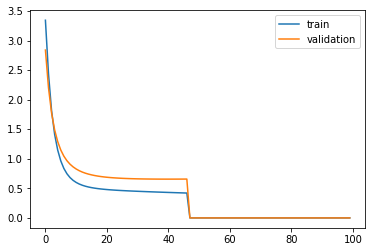

time: 237 ms (started: 2021-05-04 00:39:47 +00:00)


In [ ]:
# read model and plot graph
model_sgd = pickle.load(open(file_name_sgd,'rb'))
train_set = model_sgd['train']
test_set = model_sgd['test']
train_mae = model_sgd['train_mae']
test_mae = model_sgd['test_mae']
plt.plot([i/len(train_set) for i in train_mae])
plt.plot([i/len(test_set) for i in test_mae])
plt.legend(['train', 'validation'], loc='upper right')

### Appending metadata file - We will read metadata file corresponding to the amazon reviews dataset file(s) which were used for training-validation

We create a dictionary called, item_name_mapping, to also show titles of the items in our recommendations

In [ ]:
# reading metadata file
meta1 = read_Dataset("/content/meta_AMAZON_FASHION.json.gz")
meta2 = read_Dataset("/content/meta_All_Beauty.json.gz")
meta3 = read_Dataset("/content/meta_Appliances.json.gz")
meta4 = read_Dataset("/content/meta_Gift_Cards.json.gz")
meta5 = read_Dataset("/content/meta_Industrial_and_Scientific.json.gz")
meta6 = read_Dataset("/content/meta_Luxury_Beauty.json.gz")
meta7 = read_Dataset("/content/meta_Magazine_Subscriptions.json.gz")
meta8 = read_Dataset("/content/meta_Software.json.gz")
# metadata_df1, metadata_df2...etc if more than 1 metadata file required.

metadata_merged = pd.concat([meta1, meta2, meta3, meta4, meta5, meta6, meta7, meta8])
metadata_merged.drop_duplicates('asin')    # duplicate items with same ids
item_name_mapping = pd.Series(metadata_merged.title.values,index=metadata_merged.asin).to_dict() # item with names


time: 37.9 s (started: 2021-05-04 00:52:58 +00:00)


Appending predicted results to testset for 

In [ ]:
# Apply function to compute predicted rating by loaded model vectors and append column
p = model_sgd["user_vectors"]
q = model_sgd["item_vectors"]
user_mapping = model_sgd["user_mapping"]
item_mapping = model_sgd["item_mapping"]
test_set['SGD_predicted'] = test_set.apply(lambda row: np.dot(p[int(row.uid),:],q[:,int(row.iid)].T), axis=1)

time: 605 ms (started: 2021-05-04 00:55:06 +00:00)


In [ ]:
test_set.head()

,uid,iid,ratings,timestamp,SGD_predicted
221,0,4799,5.0,1412812800,4.933104
16441,1,5043,5.0,1503705600,4.655828
55719,2,1142,5.0,1469145600,4.373921
14685,3,1241,5.0,1473465600,4.379314
1716,4,3923,5.0,1447891200,4.951659


time: 16.6 ms (started: 2021-05-04 00:55:30 +00:00)


## Making recommendations

In [ ]:
user_id = random.choice(list(user_mapping.keys()))
recommened_items = recommend(model_sgd, 100, item_name_mapping, user_id)

AQ2S8N5JQW6LB
B00JF2GVWK: ('Caress Body Wash - Sheer Twilight - 18 oz - 2 pk', 7.086206258282886)
B00QXW95Q4: ('Theorie Argan Oil Ultimate Reform Shampoo &amp; Conditioner 27 Fl Oz Each', 7.045970420375451)
B004CALFE4: ('BVLGARI WHITE by Bvlgari for Men and Women: SHAMPOO 6.8 OZ', 7.038985908631647)
B00RZYW4RG: ('Sexy Straight Smooth and Seal Hair Spray 8.1 Ounce (Pack of 3)', 7.017599000936839)
B004KEJ65C: ('Folicure Shampoo Extra Body 12 oz. (3-Pack) with Free Nail File', 6.999847662230149)
B00VARTPKS: ('(Pack of 3) L.A. Colors Mineral Pressed Powder #Mp303 &quot;Creamy Natural&quot;', 6.9794536544441215)
B001OHV1H4: ('Avalon Grapefruit and Geranium Smoothing Shampoo, 11 Ounce', 6.939933881607862)
B00006L9LC: ('Citre Shine Moisture Burst Shampoo - 16 fl oz', 6.9167567157084315)
B0009RF9DW: ('Yardley By Yardley Of London Unisexs Lay It On Thick Hand &amp; Foot Cream 5.3 Oz', 6.912116615718289)
B00B9V9ASM: ('Pantene Pro-V Ultimate 10 2-In-1 Shampoo And Conditioner 25.4 Fl Oz (packaging